University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela   

# Lecture 7: Bayesian inference using MCMC

Background reading: please see Chapter 7 of the "Course notes" available in Moodle.


## 1. Metropolis-Hastings sampling for the posterior distribution of a probabilistic model

This exercise will illustrate a very simple example of Bayesian modelling: estimating the mean $\mu$ of a normal distribution for some observed data $\mathcal{D} = (x_i)_{i=1}^n$ that are assumed to be independent given $\mu$.

We assume $p(x_i | \mu) = \mathcal{N}(x_i;\; \mu, \sigma^2)$, i.e. the mean of $x_i$ is $\mu$ and the variance $\sigma^2 = 2$ is assumed to be fixed.

Our goal is to compute $p(\mu | \mathcal{D})$. We can obtain this from Bayes rule by specifying the prior $p(\mu)$. This will yield
$$ p(\mu | \mathcal{D}) = \frac{p(\mathcal{D} | \mu) p(\mu)}{p(\mathcal{D})} = \frac{\prod_{i=1}^n p(x_i | \mu) p(\mu)}{p(\mathcal{D})}. $$

1. Assume $p(\mu) = \mathcal{N}(\mu;\; 0, \sigma_0^2).$ Implement a Metropolis-Hastings sampler to sample from $p(\mu | \mathcal{D})$ using a normal proposal and $\sigma_0^2 = 100$. Summarise your samples by computing their mean and standard deviation. Compare your result with the mean of $\mathcal{D}$. *Hint*: the numerator of the Bayes rule will give you the target distribution as a function of $\mu$. The Metropolis-Hastings sampler does not require the normalization constant.
2. Compare the samples you obtained with the exact analytical solution for $p(\mu | \mathcal{D})$ (Sec. 7.1 of the course notes).
3. Repeat the experiment with $\sigma_0^2 = 1$. Can you still match the exact solution?
4. Try the sampler with $p(\mu) = \mathrm{Laplace}(\mu;\; 0, b_0) = \frac{1}{2b_0} \exp(-|\mu|/b_0)$ with $b_0=10$. Summarise your samples by computing their mean and standard deviation and compare with the above cases. Note that in this case there is no easily available exact solution.

Sanity check for the prior density normalization:
(0.9999999999999999, 8.671030272177694e-10)
Acceptance rate: 0.36026
Mean: 3.975675936762527; SD: 0.06348802318898503.


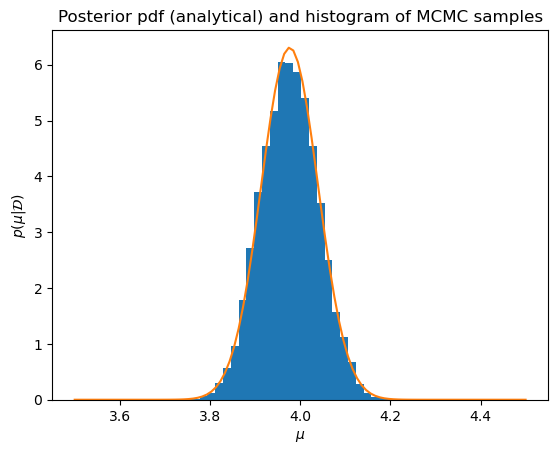

In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt

import scipy.integrate


#1

npr.seed(41)

data = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/toydata.txt', sep='\t', header=None)
data = data.values
data = np.array(data[:,0])

sigma = np.sqrt(2)

def mhsample(theta0, n, log_target, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (assumed symmetric).
    """
    theta = theta0
    accepts = 0
    lp = log_target(theta)
    thetas = np.zeros(n)
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = log_target(theta_prop)
        if np.log(npr.rand()) < l_prop - lp:
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    print('Acceptance rate:', accepts/n)
    return thetas

# Note: sigma = standard deviation, not variance
def lnormpdf(x, mu, sigma):
    """Log pdf of normal density."""
    return -0.5*np.log(2*np.pi) - np.log(sigma) - 0.5*(x-mu)**2/sigma**2

# check that the density integrates to 1
print('Sanity check for the prior density normalization:')
print(scipy.integrate.quad(lambda x: np.exp(lnormpdf(x, 0, 10)), -100, 100))
# (for MCMC, the prior does not need to be normalized, but it is useful now for visualization)

sigma0 = 10 # broad prior density
target = lambda mu: np.sum(lnormpdf(data, mu, sigma)) + lnormpdf(mu, 0, sigma0)
samples = mhsample(1.0, 100000, target, lambda x: x+0.2*npr.normal())
samples = samples[len(samples)//2:]

print('Mean: {}; SD: {}.'.format(np.mean(samples), np.std(samples)))

#2 MCMC vs. analytical solution
n = len(data)
t = np.linspace(3.5, 4.5, 100)
post_mean = sigma0**2/(sigma**2/n + sigma0**2) * np.mean(data) # posterior mean
post_var = 1/(1/sigma0**2 + n/sigma**2)                        # posterior variance

post_pdf = np.exp(lnormpdf(t, post_mean, np.sqrt(post_var)))

plt.hist(samples, 30, density=True)
plt.plot(t, post_pdf)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu|\mathcal{D})$')
plt.title(r'Posterior pdf (analytical) and histogram of MCMC samples')
plt.show()

Acceptance rate: 0.35676
Mean: 3.9608515233782904; SD: 0.06302744725937007.


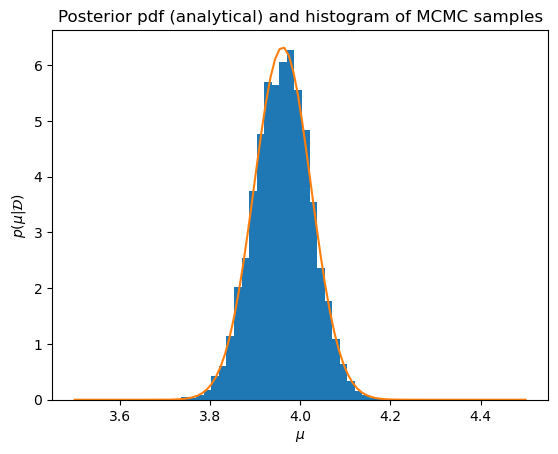

In [2]:
# 3 narrow prior density
sigma0 = 1
target2 = lambda mu: np.sum(lnormpdf(data, mu, sigma)) + lnormpdf(mu, 0, sigma0)
samples = mhsample(1.0, 100000, target2, lambda x: x+0.2*npr.normal())
samples = samples[len(samples)//2:]
print('Mean: {}; SD: {}.'.format(np.mean(samples), np.std(samples)))

n = len(data)
t = np.linspace(3.5, 4.5, 100)
plt.hist(samples, 30, density=True)
plt.plot(t, np.exp(lnormpdf(t, sigma0**2/(sigma**2/n + sigma0**2) * np.mean(data), np.sqrt(1/(1/sigma0**2 + n/sigma**2)))))
plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu|\mathcal{D})$')
plt.title(r'Posterior pdf (analytical) and histogram of MCMC samples')
plt.show()

Acceptance rate: 0.35987
Mean: 3.975128352028978; SD: 0.06318746409467874.


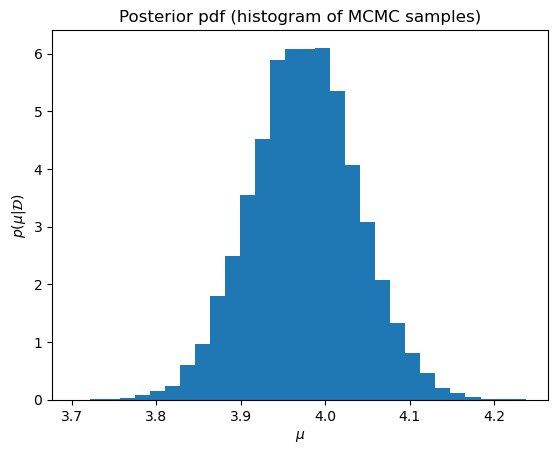

In [3]:
# 4

b0 = 10
target2 = lambda mu: np.sum(lnormpdf(data, mu, sigma)) - np.abs(mu/b0)
samples = mhsample(1.0, 100000, target2, lambda x: x+0.2*npr.normal())
samples = samples[len(samples)//2:]
print('Mean: {}; SD: {}.'.format(np.mean(samples), np.std(samples)))

n = len(data)
plt.hist(samples, 30, density=True)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu|\mathcal{D})$')
plt.title(r'Posterior pdf (histogram of MCMC samples)')
plt.show()

## 2. Metropolis-Hastings sampling of constrained parameters using transformations

In this task we will develop a Metropolis-Hastings sampler for Bayesian inference of the variance of normally distributed data. This will demonstrate the use of MH sampling for Bayesian inference as well as using transformations to enforce the positivity of the variance parameter.

The probabilistic model is as follows:
$$ p(x_i | \sigma) = \mathcal{N}(x_i ;\; 0, \sigma^2) $$
$$ p(\sigma) = \mathrm{Exponential}(\sigma ;\; 1) = e^{-\sigma}. $$ 

In order to apply standard MH sampling with an unbounded proposal, we will apply a transformation to parametrise the model using $\sigma = g(\phi) = \exp(\phi)$ such that $\phi = g^{-1}(\sigma) = \log (\sigma)$. As $\sigma \in \mathbb{R}^+$, $\phi \in \mathbb{R}$.

We can derive the distribution over $\phi$ using the change of variables formula (see Sec. 7.3.3 of the course notes):
$$ p_\phi(\phi) = p_\sigma(\sigma) \left| \frac{\mathrm{d}g}{\mathrm{d}\phi} \right| $$

1. Express and plot the prior density $p(\phi)$ using $p(\sigma)$, when $\sigma = g(\phi) = \exp(\phi)$.
2. Check that your density is valid by evaluating $\int_{-\infty}^{\infty} p_\phi(\phi) \mathrm{d}\phi$.
3. Generate a data set of 10 points $x_i$ with $x_i \sim \mathcal{N}(0, 2^2)$ (zero-mean normal with variance 2^2).
4. Implement a MH sampler to sample $\phi$ when $\log \pi^*(\phi) = \sum_{i=1}^{10} \log p(x_i | \phi) + \log p(\phi)$ using $Q(\phi' ; \phi) = \mathcal{N}(\phi' ;\; \phi, 1)$ as the proposal.
5. Plot a histogram of the obtained samples for $\sigma$. (*Hint*: remember to transform $\phi$ back to $\sigma$.)

In [4]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.integrate

npr.seed(41)

# 1

Prior in original space:
$$p_\sigma(\sigma) = \exp(-\sigma).$$

Transformation and inverse transform:
$$\sigma = g(\phi) = \exp(\phi) \qquad \Longrightarrow \qquad \phi = g^{-1}(\sigma) = \log(\sigma).$$

Change of variables formula:
$$ p_\phi(\phi) = p_\sigma(\sigma) \left| \frac{\mathrm{d}g}{\mathrm{d}\phi} \right|.$$

We have
$$
\left| \frac{\mathrm{d}g}{\mathrm{d}\phi} \right| = \exp(\phi)
$$
so the transformed prior (and log prior) are:
$$p_\phi(\phi) = \exp\left( -\exp(\phi) \right) \cdot \exp(\phi) \quad \Longrightarrow \quad \log p_\phi(\phi) = -\exp(\phi) + \phi.$$

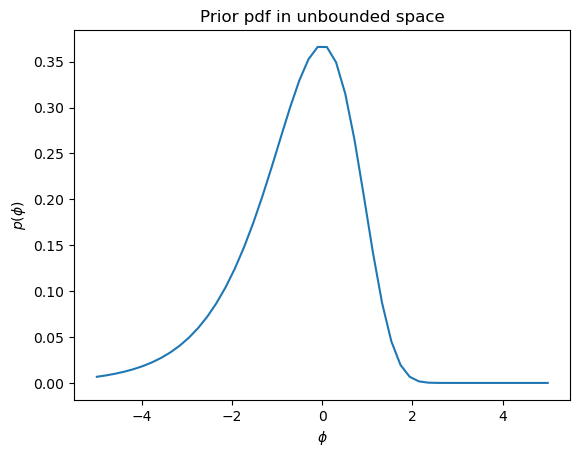

Sanity check for the prior density normalization (integral and error):
(0.999999999999907, 3.0853251283166425e-09)


In [5]:
def logp_phi(phi):
    """Transformed log prior density."""
    return -np.exp(phi) + phi

t = np.linspace(-5, 5, 50)
plt.plot(t, np.exp(logp_phi(t)))
plt.xlabel(r'$\phi$')
plt.ylabel(r'$p(\phi)$')
plt.title(r'Prior pdf in unbounded space')
plt.show()

# 2 Transformed pdf should still integrate to 1

print('Sanity check for the prior density normalization (integral and error):')
print(scipy.integrate.quad(lambda x: np.exp(logp_phi(x)), -30, 30))

Acceptance rate: 0.256


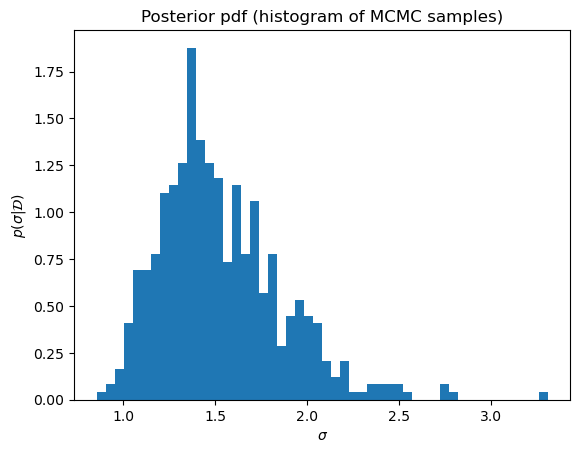

Data std: 1.3628345971800508
Posterior mean of sigma: 1.54186360914181


In [6]:
# 3 Generate ten data points
d = npr.normal(0, 2, 10)

# 4

# Note that now Q(phi',phi^(t)) = Q(phi^(t), phi') so we do not need to include Q(phi'; phi) term for the acceptance probability
samples = mhsample(0.0, 10000,
#                  lambda sigma: logp_sigma(sigma) + np.sum(lnormpdf(d, 0, sigma)),
                  lambda phi: logp_phi(phi) + np.sum(lnormpdf(d, 0, np.exp(phi))),
                  lambda phi: phi+npr.randn())
samples = samples[len(samples)//2:]

# 5

plt.hist(np.exp(samples[::10]), 50, density=True)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p(\sigma|\mathcal{D})$')
plt.title(r'Posterior pdf (histogram of MCMC samples)')
plt.show()

print('Data std:', np.std(d))
print('Posterior mean of sigma:', np.mean(np.exp(samples)))

## 3. MCMC with an asymmetric proposal

In this exercise we will study MCMC sampling in a discrete space, the set of integers $\{1, 2, \dots, 21\}$.

The target distribution will be the uniform distribution over the points
$$p(n) = \begin{cases} 1/21 \text{ when } 1 \le n \le 21 \\ 0 \text{ otherwise}. \end{cases},$$
and the proposal is 
$$q(n'; n) = \begin{cases} 1/2 \text{ when } |n' - n| = 1 \\ 0 \text{ otherwise} \end{cases}$$

1. Implement the sampler and test it by running it for 100000 iterations.
2. As jumps from 1 to 0 and from 21 to 22 are always rejected, we could try optimising the sampler by using an alternative proposal
$$ q'(n'; n) = \begin{cases} 1 \text{ when } (n, n') \in \{(1, 2), (21, 20)\} \\ 1/2 \text{ when } 2 \le n \le 20 \wedge |n' - n| = 1 \\ 0 \text{ otherwise}. \end{cases}$$
Implement this proposal but do not include the $\frac{q(n;n')}{q(n';n)}$ term in the acceptance ratio. Which distribution is the sampler now sampling from?
3. Fix the sampler by using the full acceptance rule. Can you get it to sample from the uniform distribution?

*Hint*: Note that it is fine to use $-\infty$ as $\log 0$ (use `-np.inf`). This is going to be useful for code working with log-probabilities.

Acceptance rate: 0.95238


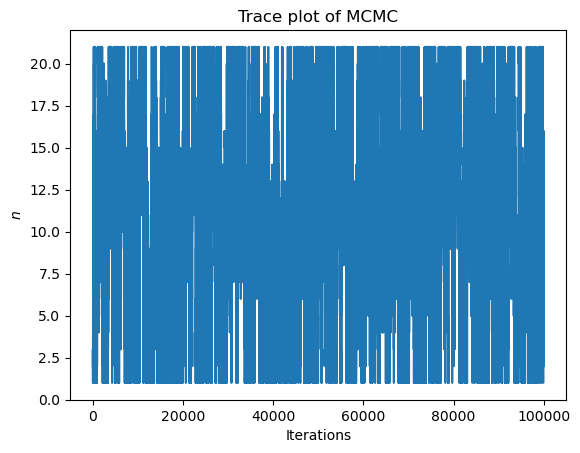

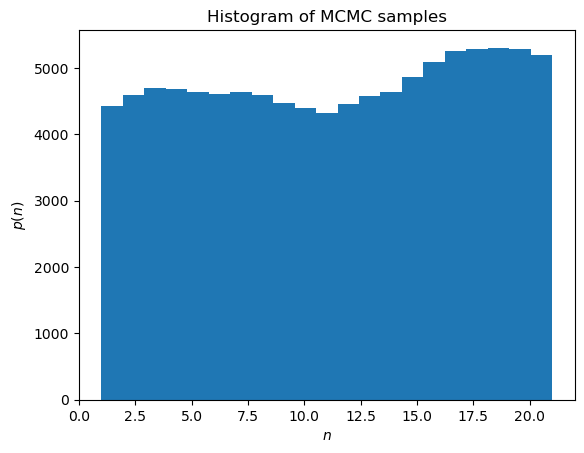

In [7]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

# 1
npr.seed(41)

def logtarget(theta):
    """Log target distribution (uniform)."""
    if theta >= 1 and theta <= 21:
        return -np.log(21)
    else:
        return -np.inf

def proposal1(x):
    """Proposal distribution (+/-1)"""
    return x+npr.choice(np.array([-1, 1]))
    
samples = mhsample(3, 100000, logtarget, proposal1)
plt.plot(samples)
plt.xlabel(r'Iterations')
plt.ylabel(r'$n$')
plt.title(r'Trace plot of MCMC')
plt.show()

h = plt.hist(samples, 21)
plt.xlabel(r'$n$')
plt.ylabel(r'$p(n)$')
plt.title(r'Histogram of MCMC samples')
plt.show()


Acceptance rate: 1.0


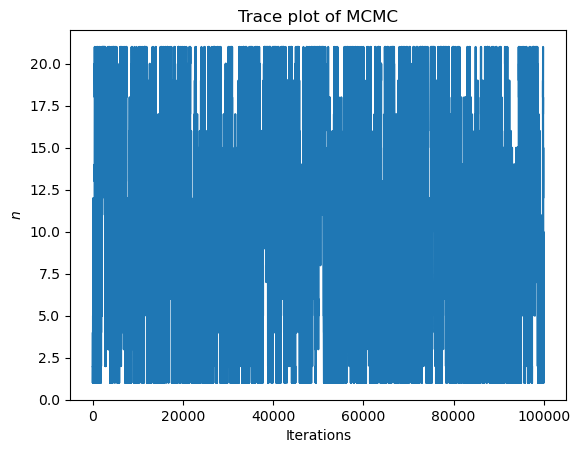

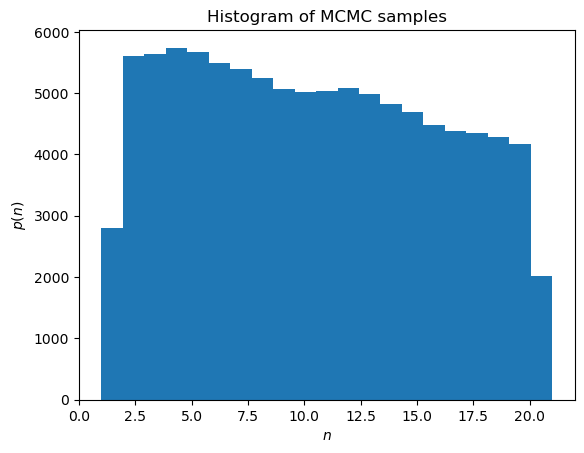

In [8]:
# 2

def proposal2(x):
    """Proposal that takes care of boundaries."""
    if x == 1:
        return 2
    if x == 21:
        return 20
    return x+npr.choice(np.array([-1, 1]))

npr.seed(43)
samples = mhsample(3, 100000, logtarget, proposal2)
plt.plot(samples)
plt.xlabel(r'Iterations')
plt.ylabel(r'$n$')
plt.title(r'Trace plot of MCMC')
plt.show()

h = plt.hist(samples, 21)
plt.xlabel(r'$n$')
plt.ylabel(r'$p(n)$')
plt.title(r'Histogram of MCMC samples')
plt.show()

Acceptance rate: 0.9541666666666667


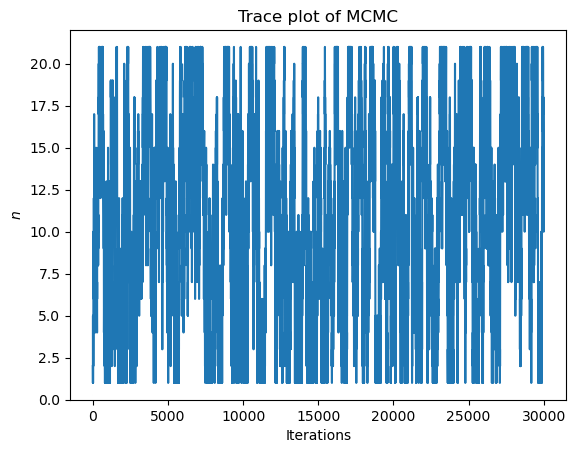

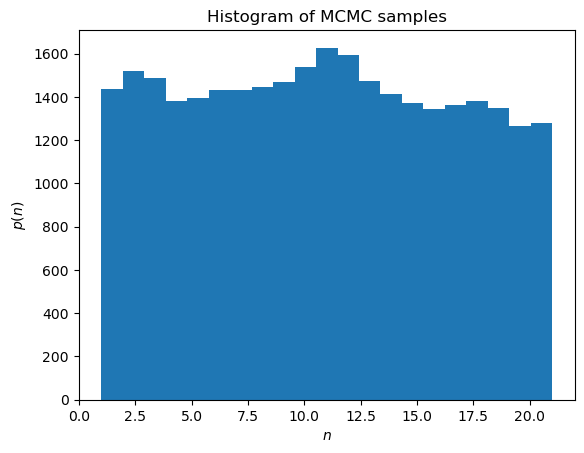

In [9]:
# 3

def mhsample_asym(theta0, n, target, proposal, drawproposal):
    """
    Metropolis-Hastings sampler for n samples from starting point theta0.
    log_target is the log of the target pdf, and 
    drawproposal samples from the proposal (can be asymmetric).
    """    
    theta = theta0
    accepts = 0
    lp = target(theta)
    thetas = np.zeros(n)
    for i in range(n):
        theta_prop = drawproposal(theta)
        l_prop = target(theta_prop)
        if np.log(npr.rand()) < (l_prop - lp
                                 + proposal(theta_prop, theta)
                                 - proposal(theta, theta_prop)
                                 ):
            theta = theta_prop
            lp = l_prop
            accepts += 1
        thetas[i] = theta
    print('Acceptance rate:', accepts/n)
    return thetas

def logproposal2(x, y):
    """Updated proposal log pdf."""
    if x == 1 and y == 2:
        return 0 # np.log(1)
    if x == 21 and y == 20:
        return 0 # np.log(1)
    if np.abs(x - y) == 1:
        return np.log(0.5)
    else:
        return -np.inf

npr.seed(43)
samples = mhsample_asym(3, 30000, logtarget, logproposal2, proposal2)

plt.plot(samples)
plt.xlabel(r'Iterations')
plt.ylabel(r'$n$')
plt.title(r'Trace plot of MCMC')
plt.show()

h = plt.hist(samples, 21)
plt.xlabel(r'$n$')
plt.ylabel(r'$p(n)$')
plt.title(r'Histogram of MCMC samples')
plt.show()

## 4. Gibbs sampling

Gibbs sampling is a popular special form of multivariate Metropolis-Hastings sampling where a vector of variables $\theta = (\theta_1, \dots, \theta_n)$ is updated cyclically one at a time $\theta_1, \theta_2, \dots, \theta_n, \theta_1, \theta_2, \dots$. For each update, $\theta_i$ is drawn from the conditional distribution $p(\theta_i | \theta_{\setminus i})$ given the other variables $\theta_{\setminus i}$ (i.e., all the other $\theta$s minus $\theta_i$). What makes Gibbs sampling a popular choice is that for some probabilistic models the conditional distribution is available analytically.

Implement the Gibbs sampler to draw samples from a 2-dimensional multivariate normal with zero mean $\mu = (0, 0)$ and covariance $\Sigma = \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$ as described at https://theclevermachine.wordpress.com/2012/11/05/mcmc-the-gibbs-sampler/

Plot the trace plots and normed histograms of your samples. Test your sampler with different values of $\rho$. What do you observe?

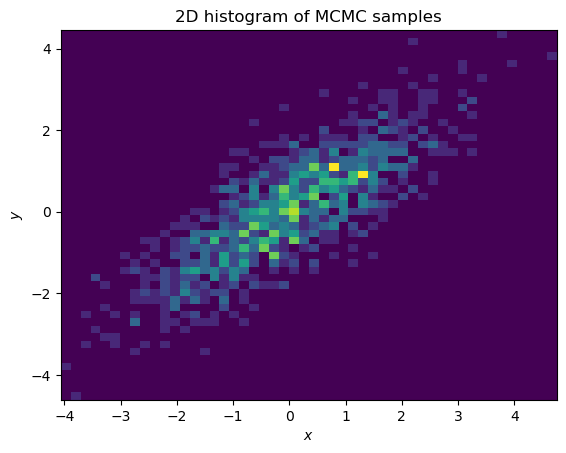

In [10]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

npr.seed(41)

rho = 0.8
def conditional_draw(x):
    """Conditional draw given current location of the other variable (works for this example, not in general)."""
    return npr.normal(loc=rho*x, scale=np.sqrt(np.sqrt(1-rho**2)))

def gibbs2d(theta0, n, conditional_draw):
    """Gibbs sampler (2D)."""
    d = 2
    theta = theta0
    thetas = np.zeros([n, d])
    for t in range(n):
        for i in range(d):
            theta[i] = conditional_draw(theta[1-i])
        thetas[t]=theta
    return thetas

samples = gibbs2d(np.zeros(2), 10000, conditional_draw)
plt.hist2d(samples[::10, 0],samples[::10, 1], 50, density=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'2D histogram of MCMC samples')
plt.show()